In [11]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
pd.options.display.max_rows = 4000
import numpy as np

In [12]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

In [13]:
# ylabel_name = 'marions_ylabels_esd_removed'
ylabel_name = 'marions_ylabels'
data_features = pd.read_csv("data/optimal_features.csv")
clustering_features = plotting.extract_numerical_features(data_features)

In [14]:
# ylabel_name = 'marions_ylabels_deduction'
ylabel_to_cluster_num = {'Outlier':-1, 'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
cluster_num_to_ylabel = {v: k for k, v in ylabel_to_cluster_num.items()}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
marions_labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data

# Plot Labeled Data Only

# Used for Correcting Labels

In [15]:
def loss(pseudo_labels:pd.Series, actual_labels:pd.Series):
    pseudo_actual_intersection = pseudo_labels.loc[actual_labels.index]
    diff_mask = pseudo_actual_intersection != actual_labels
    diff_labels = pseudo_actual_intersection[diff_mask]
    return diff_labels.index

def correct_pseudo_ylabels_to_actual(pseudo_labels:pd.Series, actual_labels:pd.Series, changed_ylabel_idxs) -> pd.Series:
    corrected_pseudo_labels = pseudo_labels.copy()
    corrected_pseudo_labels.loc[changed_ylabel_idxs] = actual_labels
    return corrected_pseudo_labels

# Changed Curve Filenames

In [16]:
def find_changed_label_filenames(marions_labeled_data:pd.DataFrame, 
                                 predicted:pd.DataFrame,
                                 label_to_num_map: dict):
    labeled_data_predictions = predicted[marions_labeled_data.index]
    labeled_data_actual = marions_labeled_data[f'{ylabel_name}_nums']
    diff_labels_mask = labeled_data_predictions != labeled_data_actual

    for i in marions_labeled_data[diff_labels_mask].index:
        print(
            f"{marions_labeled_data.loc[i, 'filenames']}: "
            f"{label_to_num_map[int(marions_labeled_data.loc[i, f'{ylabel_name}_nums'])]} "
            f"-> {label_to_num_map[int(labeled_data_predictions[i])]}"
        )

# Nearest Centroid
- Each class is represented by it's centroid, with test sample classified to the class with the nearest centroid

loss: Index([  1,   3,   4,  29,  30,  32,  33,  37,  44,  45,  48,  50,  53,  60,
        61,  63,  64,  73,  74,  79,  80,  82,  83,  88,  92, 101, 109],
      dtype='int64')
1      WS23_L3_T1_P_10.csv
3       WS23_L3_T1_P_1.csv
4       WS23_L3_T1_P_8.csv
29     WS23_L3_T1_P_13.csv
30     WS23_L3_T1_P_16.csv
32     WS23_L2_T1_P_13.csv
33      WS23_L2_T1_P_5.csv
37      WS23_L2_T1_P_7.csv
44      WS23_L3_T1_P_5.csv
45      WS23_L3_T1_P_3.csv
48      WS23_L3_T1_P_2.csv
50     WS23_L2_T1_P_16.csv
53      WS23_L2_T1_P_1.csv
60     WS23_L2_T1_P_14.csv
61      WS23_L2_T1_P_3.csv
63     WS23_L3_T1_P_15.csv
64     WS23_L3_T1_P_11.csv
73     WS23_L3_T1_P_14.csv
74     WS23_L2_T1_P_11.csv
79     WS23_L2_T1_P_15.csv
80     WS23_L2_T1_P_17.csv
82     WS23_L2_T1_P_10.csv
83     WS23_L3_T1_P_19.csv
88     WS23_L2_T1_P_12.csv
92      WS23_L2_T1_P_6.csv
101    WS23_L3_T1_P_17.csv
109    WS23_L3_T1_P_21.csv
Name: filenames, dtype: object


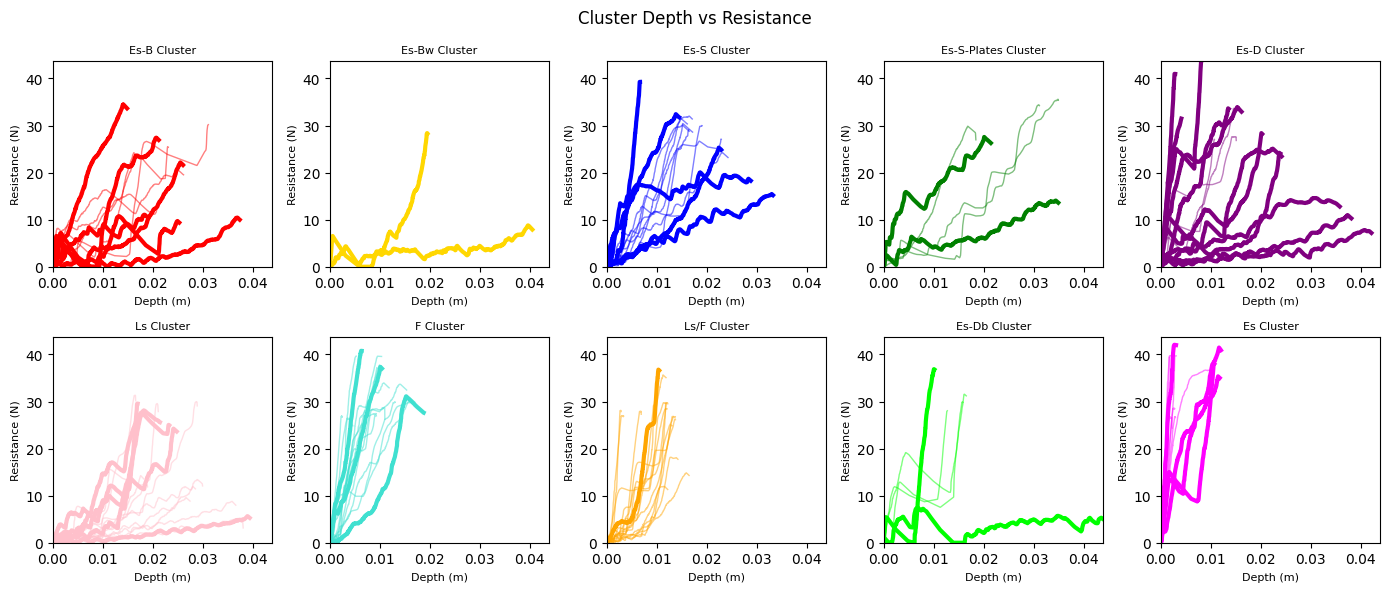

    Eigenvalue  Proportion  Cumulative
PC                                    
1     2.737603    0.542543    0.542543
2     1.210187    0.239837    0.782380
3     0.504408    0.099964    0.882345
4     0.388207    0.076936    0.959280
5     0.205467    0.040720    1.000000


                                PC1       PC2       PC3       PC4       PC5
largest_force_drop_size    0.413916 -0.567279  0.357591 -0.213576  0.577392
force_mean                -0.478435 -0.333088  0.515370 -0.426435 -0.461194
curve_first_quarter_slope -0.449658 -0.425918  0.071779  0.768504  0.143703
rsquared                  -0.405068  0.572906  0.439329 -0.064724  0.557225
depth_max                  0.483220  0.240043  0.639030  0.421604 -0.350383


In [17]:
from sklearn.neighbors import NearestCentroid

X = plotting.extract_numerical_features(marions_labeled_data).values.tolist()
y = marions_labeled_data[f'{ylabel_name}_nums'].values.tolist()
nc = NearestCentroid()
nc.fit(X,y)
nc_predictions = pd.Series(nc.predict(clustering_features.values))

nc_actual = marions_labeled_data[f'{ylabel_name}_nums']
nc_changed_ylabel_idxs = loss(nc_predictions, nc_actual)
print(f'loss: {nc_changed_ylabel_idxs}')
nc_corrected_predictions = correct_pseudo_ylabels_to_actual(nc_predictions, nc_actual, nc_changed_ylabel_idxs)

print(data_features.loc[nc_changed_ylabel_idxs]['filenames'])

# ground truth don't move
plotting.plot_cluster_subplots(nc_corrected_predictions, curve_data, 
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=cluster_num_to_ylabel,
                                  bold_idxs=nc_actual.index
                                  )

# # ground truth move
# plotting.plot_cluster_subplots(nc_predictions, curve_data,
#                                   clustering_method="Nearest Centroid", 
#                                   cluster_category_names=cluster_num_to_ylabel,
#                                   pseudo_corrections=nc_corrected_predictions,
#                                   bold_idxs=nc_actual.index
#                                   )

# plotting.pca_analysis(marions_labeled_data)

# pca plot Marion's labeled points 
centroids = pd.DataFrame(data=nc.centroids_, columns=plotting.extract_numerical_features(marions_labeled_data).columns)
centroids[f'{ylabel_name}_nums'] = nc.classes_
plotting.plot_pca(marions_labeled_data, marions_labeled_data[f'{ylabel_name}_nums'], 3,
                  graph_title=f'',
                  ylabel_name=ylabel_name,
                  centroids=centroids)

# plot all points and their pseudo labels
plotting.plot_pca(clustering_features, nc_predictions, 3,
                  graph_title=f'',
                  ylabel_name=ylabel_name,
                  centroids=centroids)

plotting.pca_analysis(clustering_features)

# Random Forest Classifier

loss_idxs: Index([], dtype='int64')


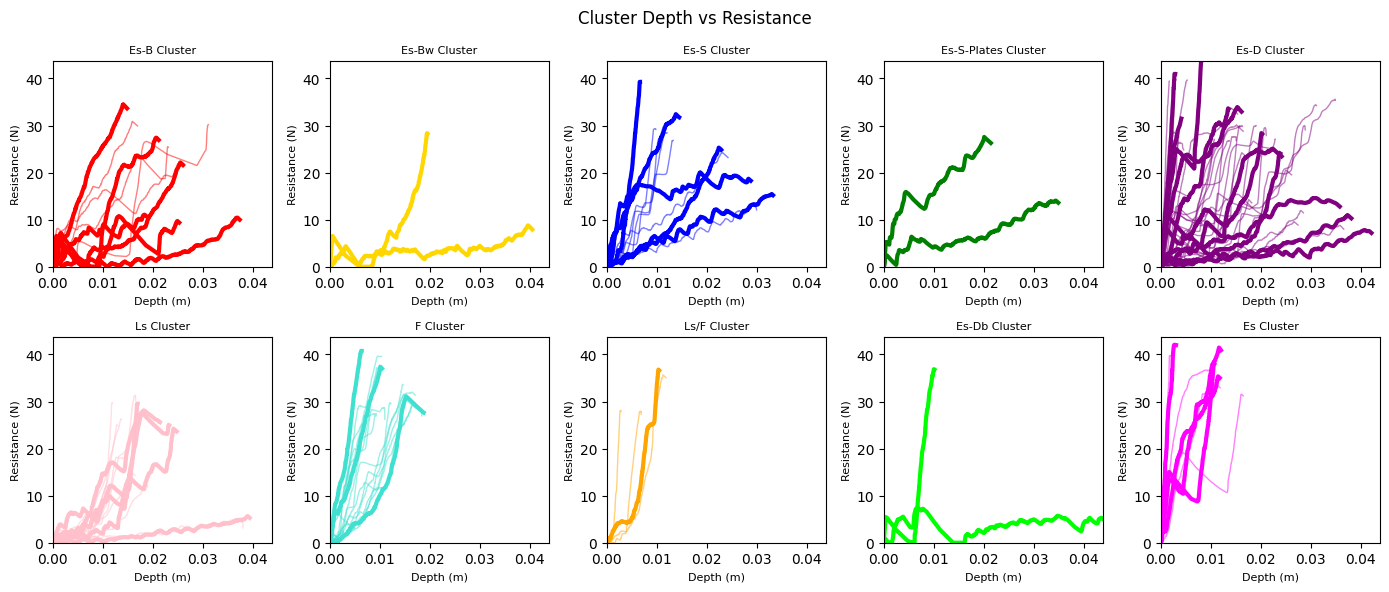

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
X = plotting.extract_numerical_features(marions_labeled_data).to_numpy()
y = marions_labeled_data[f'{ylabel_name}_nums']
rf_clf.fit(X, y)
rf_clf_y_pred = pd.Series(rf_clf.predict(clustering_features.values))

loss_idxs = loss(rf_clf_y_pred, y)
print(f'loss_idxs: {loss_idxs}')

plotting.plot_cluster_subplots(rf_clf_y_pred, curve_data, 
                                clustering_method="Nearest Centroid", 
                                cluster_category_names=cluster_num_to_ylabel,
                                bold_idxs=marions_labeled_data.index
                                )


# K-Nearest-Neighbor
- From the k nearest points, assign query point to the highest frequency label
- Performs better when data is uniformly distributed in feature space (clusters all have similar desnity)

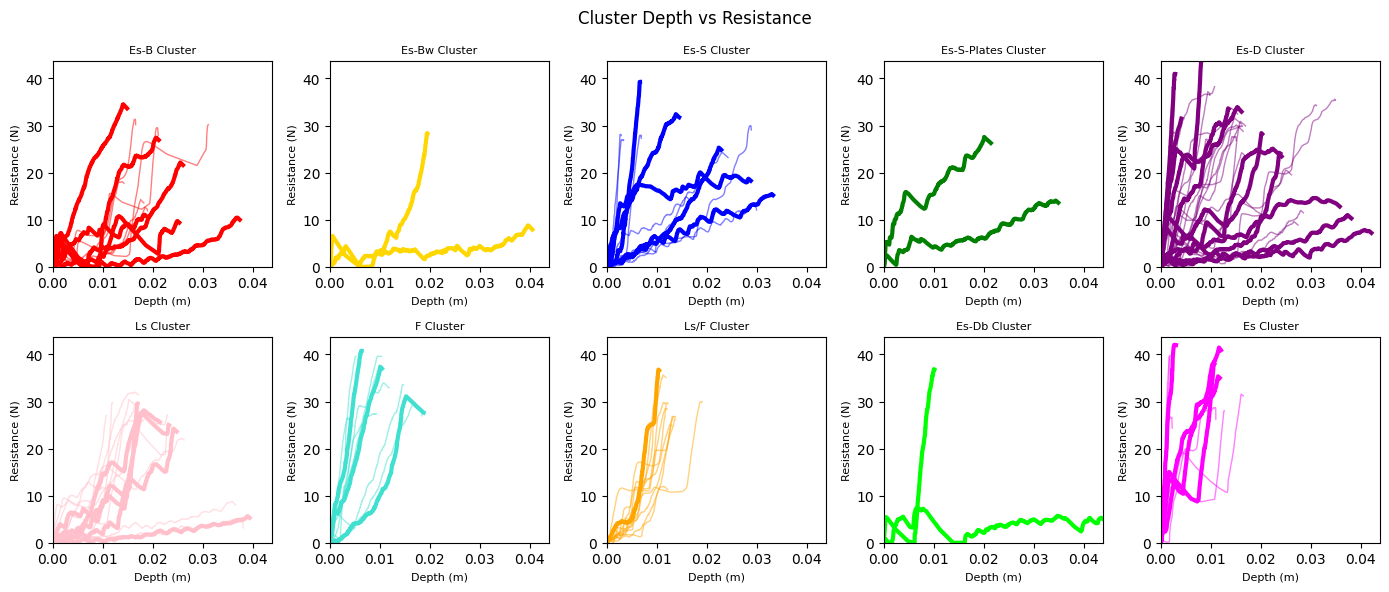

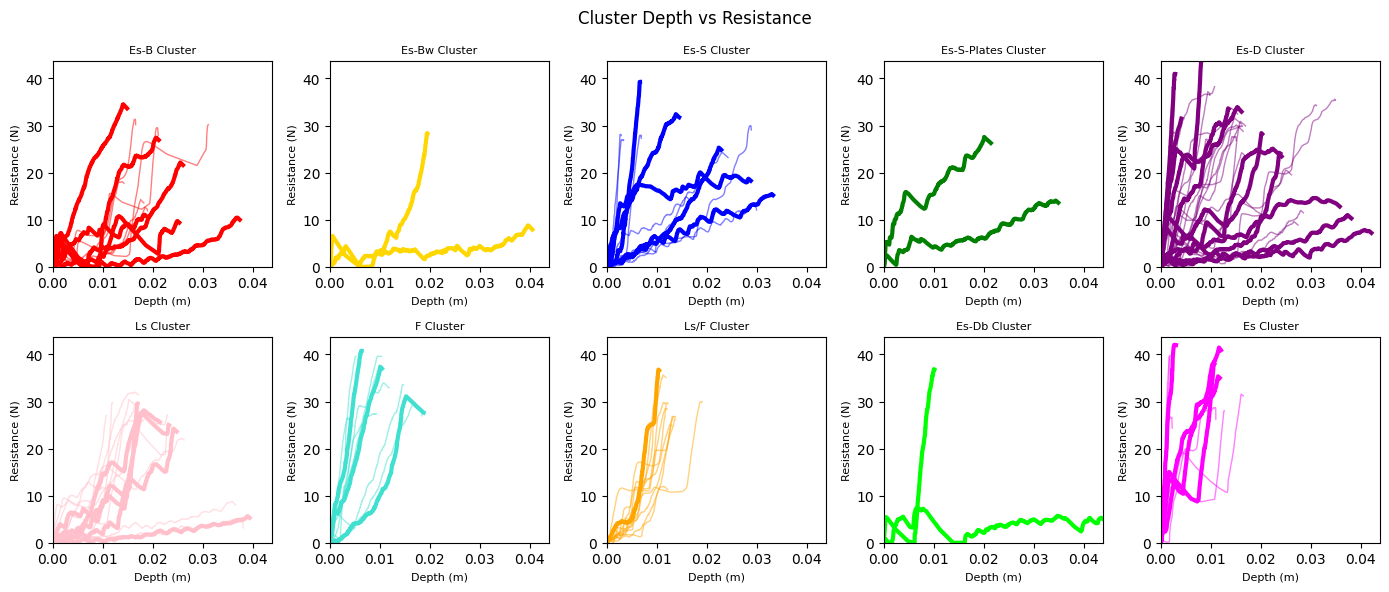

In [19]:
from sklearn.neighbors import KNeighborsClassifier

X = plotting.extract_numerical_features(marions_labeled_data).values.tolist()
y = marions_labeled_data[f'{ylabel_name}_nums'].values.tolist()

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
knn_predictions = pd.Series(knn.predict(clustering_features.values))
knn_actual = marions_labeled_data[f'{ylabel_name}_nums']
knn_changed_ylabel_idxs = loss(knn_predictions, knn_actual)
knn_corrected_predictions = correct_pseudo_ylabels_to_actual(knn_predictions, knn_actual, knn_changed_ylabel_idxs)

plotting.plot_cluster_subplots(knn_predictions, curve_data,
                                  clustering_method="K-Nearest Neighbor", 
                                  cluster_category_names=cluster_num_to_ylabel,
                                  pseudo_corrections=knn_corrected_predictions,
                                  bold_idxs=knn_actual.index
                                  )
plotting.plot_cluster_subplots(knn_corrected_predictions, curve_data, 
                                  clustering_method="K-Nearest Neighbor", 
                                  cluster_category_names=cluster_num_to_ylabel,
                                  bold_idxs=knn_actual.index)
plotting.plot_pca(clustering_features, knn_predictions, 3, 
                  graph_title=f'',
                  ylabel_name=ylabel_name,)

# Radius Neighbors Classifier
- Within radius r, assing query point to highest frequency label
- Good for when data isn't uniformly distributed (clusters have different densities)

/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/neighbors/_classification.py:864: UserWarning:

Outlier label -1 is not in training classes. All class probabilities of outliers will be assigned with 0.



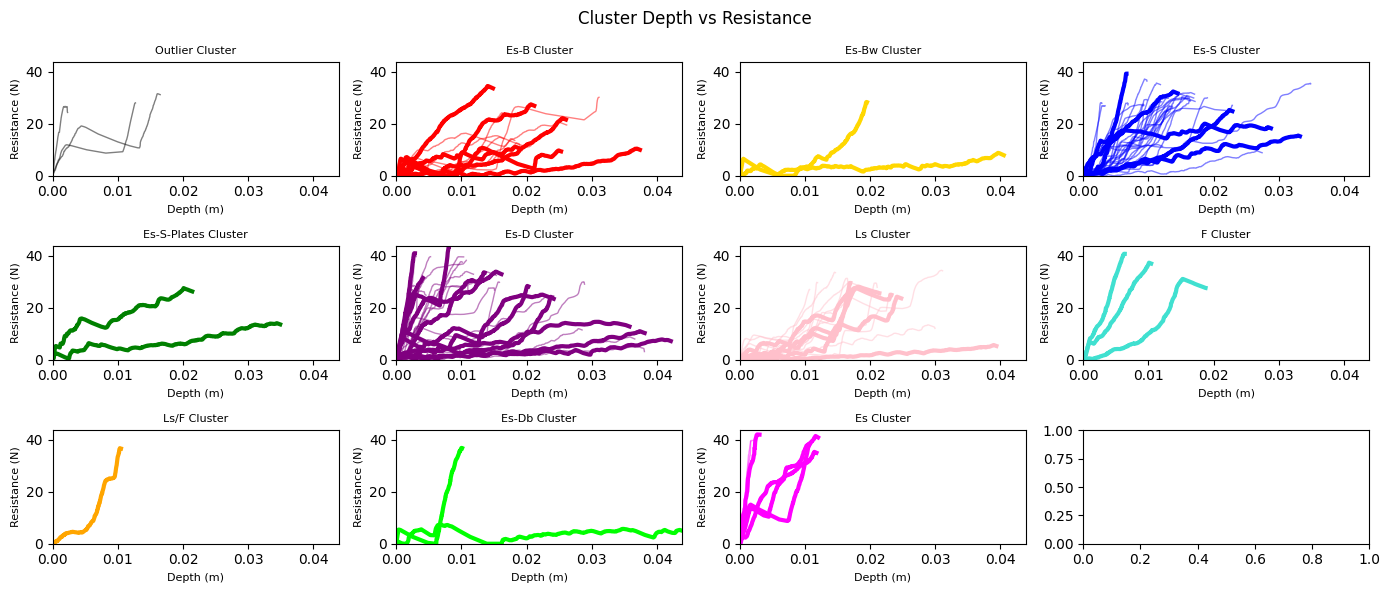

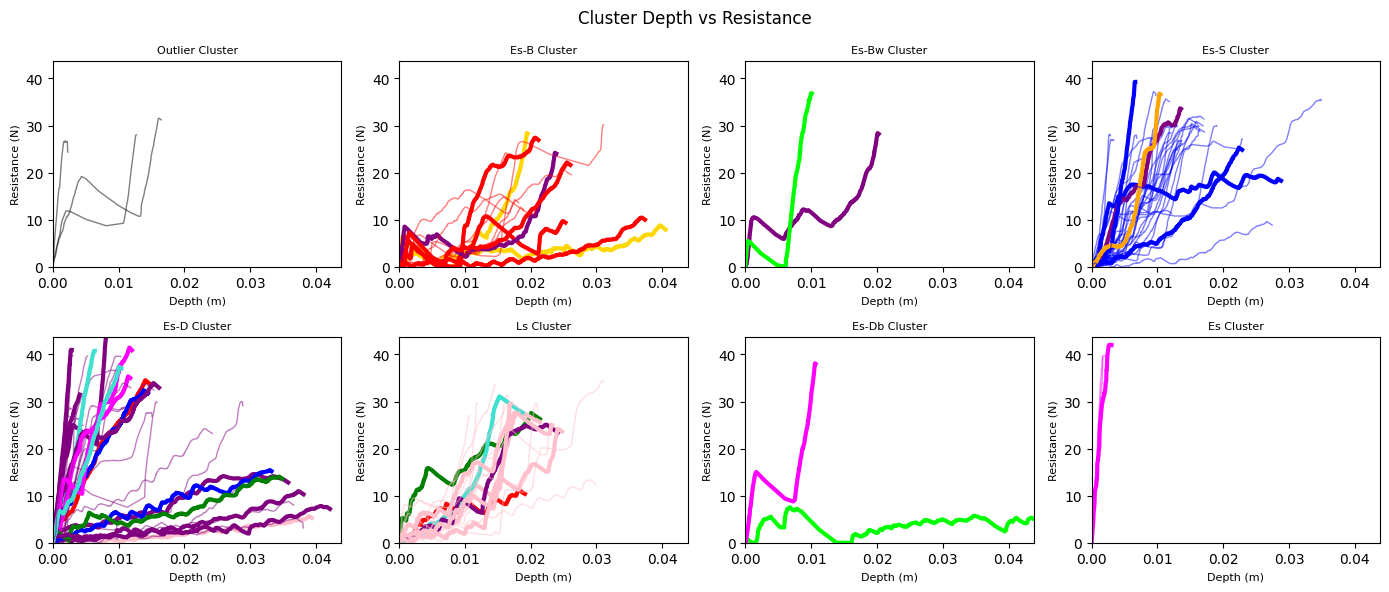

In [20]:
from sklearn.neighbors import RadiusNeighborsClassifier


X = plotting.extract_numerical_features(marions_labeled_data).values.tolist()
y = marions_labeled_data[f'{ylabel_name}_nums'].values.tolist()
rn = RadiusNeighborsClassifier(radius=1.5, outlier_label=-1)
rn.fit(X,y)
rn_predictions = pd.Series(rn.predict(clustering_features.values))

rn_actual = marions_labeled_data[f'{ylabel_name}_nums']
rn_changed_ylabel_idxs = loss(rn_predictions, rn_actual)
rn_corrected_predictions = correct_pseudo_ylabels_to_actual(rn_predictions, rn_actual, rn_changed_ylabel_idxs)

plotting.plot_cluster_subplots(rn_corrected_predictions, curve_data, 
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=cluster_num_to_ylabel,
                                  bold_idxs=rn_actual.index
                                  )
plotting.plot_cluster_subplots(rn_predictions, curve_data,
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=cluster_num_to_ylabel,
                                  pseudo_corrections=rn_corrected_predictions,
                                  bold_idxs=rn_actual.index
                                  )
plotting.plot_pca(clustering_features, rn_predictions, 3, 
                  graph_title=f'',
                  ylabel_name=ylabel_name,)